In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
from collections import namedtuple

# Завдання 4

$$
\Theta \sim \mathcal N (\mu, \tau^2), \quad \mu, \tau - \text{known}
$$
$$
Y \sim \mathcal N ( \Theta, \sigma^2), \quad \sigma - \text{known}
$$

Хочемо оцінити $\Theta$ за спостереженим $y$ та відомими $\mu,\sigma,\tau$

Будуємо ланцюг Маркова, для якого інваріантним буде наступний розподіл:
$$
f(\theta|y) \sim \exp\{-\frac{(y-\theta)^2}{2\sigma^2} - \frac{(\theta-\mu)^2}{2\tau^2}\}
$$

---

Теоретичні значення маточікування та дисперсії $\Theta$:
$$
M(\Theta | Y=y) = \frac{\sigma^{-2}}{\sigma^{-2} + \tau^{-2}} \cdot y + \frac{\tau^{-2}}{\sigma^{-2} + \tau^{-2}} \cdot \mu
$$
$$
D(\Theta | Y=y) = \frac{1}{\sigma^{-2} + \tau^{-2}}
$$

---

Пропозиція: $x' = x_n+\varepsilon_n$
- $\varepsilon_n \sim \mathcal N (0,d^2)$, $\varepsilon_n - i.i.d.$

Критерій прийняття пропозиції:
- $\alpha(x,x') = \min\left(1, \frac{f(x'|y)}{f(x|y)}\right)$
- $x_{n+1} = x'$ якщо $u \le \alpha(x,x')\quad$, де $u \sim U(0,1)$

---

В цьому алгоритмі потрібні нормально розподілені псевдовипадкові величини. Але генератори псевдовипадкових чисел в комп'ютерах видають рівномірно розподілені числа. 

Існують алгоритми отримання нормального розподілу з рівномірного. Сьогодні зазвичай використовуються Marsaglia polar method (покращений Box–Muller transform, що відображає $[0,1]^2$ у $[0,1]^2$ певним чином, даючи в результаті нормальний розподіл) для процесорів, що підтримують векторизовані обчислення (SIMD); та Ziggurat algorithm (я так і не встиг достатньо розібратися з принципом його роботи) для процесорів без SIMD.

А тепер можна зі спокійною душею використовувати бібліотечну функцію нормального розподілу

In [57]:
Task4Params = namedtuple('Task4Params', 'y,mu,sigma2,tau2,d2')
Task4Result = namedtuple('Task4Result', 'nsteps, history')
def Task4(params: Task4Params, stat_offset=2000, n_steps=2000, seed=42, debug=False):
    rng = np.random.default_rng(seed)
    y,mu,sigma2,tau2,d2 = params

    # f(\theta|y), \theta=x
    def f(x):
        return np.exp((-np.square(y-x)/sigma2 - np.square(x-mu)/tau2)/2)
    # x is a current state
    # u is a proposed state
    def alpha(x, u):
        return np.minimum(1, f(u)/f(x))

    # modelling
    state = y # initial state
    history = [state]
    
    for step in range(n_steps+stat_offset):
        proposition = state + rng.normal(0, d2)  
        w = rng.random()
        alp = alpha(state, proposition)
        if w <= alp:
            state = proposition
        history.append(state)
        
    return Task4Result(n_steps, history)


Теоретичні значення $M\Theta, D\Theta$:
$$
M(\Theta | Y=3) = \frac{1}{1+1/4}\cdot 3 + \frac{1/4}{1+1/4} \cdot 0 = \frac{4}{5} \cdot 3 = 0.8 \cdot 3 = 2.4
$$
$$
D(\Theta | Y=3) = \frac{1}{1+1/4} = 0.8
$$

In [58]:
def Test(seed=42):
    params = Task4Params(
        y=3, mu=0, sigma2=1, tau2=4, d2=1
    )
    result = Task4(params, stat_offset=2000, n_steps=10000, seed=seed)
    samples = np.array(result.history)

    sample_variance = samples.var()
    sample_mean = samples.mean()

    print(f"For rng seed {seed}:")
    print(f"> Sample mean: {sample_mean} (theor: 2.4)")
    print(f"> Sample variance: {sample_variance} (theor: 0.8)")

Test(1)
Test(10)
Test(100)
Test(1000)

For rng seed 1:
> Sample mean: 2.3684938830309394 (theor: 2.4)
> Sample variance: 0.7792171471370545 (theor: 0.8)
For rng seed 10:
> Sample mean: 2.38547503124418 (theor: 2.4)
> Sample variance: 0.7867028562420171 (theor: 0.8)
For rng seed 100:
> Sample mean: 2.4162421677722916 (theor: 2.4)
> Sample variance: 0.8032188615687955 (theor: 0.8)
For rng seed 1000:
> Sample mean: 2.3800494048377114 (theor: 2.4)
> Sample variance: 0.805542983353564 (theor: 0.8)


In [59]:
params = Task4Params(
        y=3, mu=0, sigma2=1, tau2=4, d2=1
    )
result = Task4(params, stat_offset=2000, n_steps=10000, seed=1000)
samples = np.array(result.history)

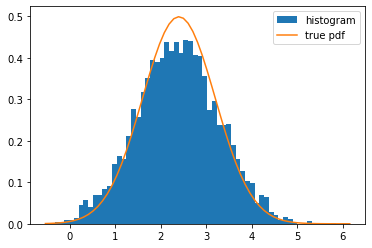

In [60]:
hist = plt.hist(samples, bins=64, density=True, label='histogram')
plt.plot(hist[1], sp.stats.norm(2.4, 0.8).pdf(hist[1]), label='true pdf')
plt.legend()

Text(0.5, 1.0, 'X_n для n=0->3000 (d=1)')

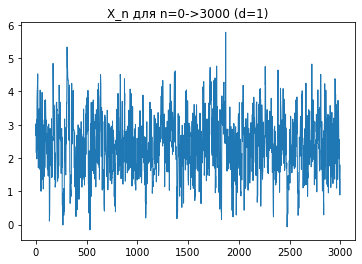

In [61]:
params = Task4Params(
        y=3, mu=0, sigma2=1, tau2=4, d2=1
    )
result = Task4(params, stat_offset=2000, n_steps=10000, seed=1000)
samples = np.array(result.history)

plt.plot(np.arange(0, 3000), samples[0:3000], '-', lw=1)
plt.title("X_n для n=0->3000 (d=1)")

Text(0.5, 1.0, 'X_n для n=0->10000 (d=100)')

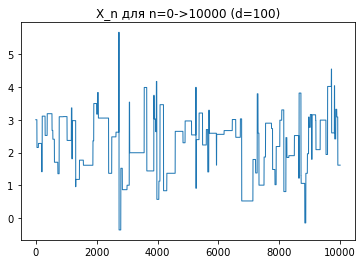

In [66]:
params = Task4Params(
        y=3, mu=0, sigma2=1, tau2=4, d2=100
    )
result = Task4(params, stat_offset=2000, n_steps=10000, seed=1000)
samples = np.array(result.history)

plt.plot(samples[0:10000], '-', lw=1)
plt.title("X_n для n=0->10000 (d=100)")

Text(0.5, 1.0, 'X_n для n=0->10000 (d=0.01)')

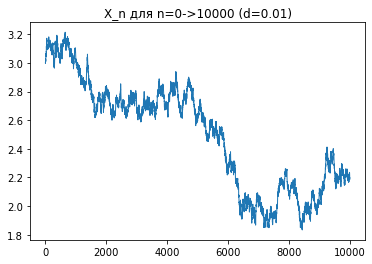

In [67]:
params = Task4Params(
        y=3, mu=0, sigma2=1, tau2=4, d2=0.01
    )
result = Task4(params, stat_offset=2000, n_steps=10000, seed=1000)
samples = np.array(result.history)

plt.plot(np.arange(0, 10000), samples[0:10000], '-', lw=1)
plt.title("X_n для n=0->10000 (d=0.01)")